In [1]:
import snowflake.connector
import pandas as pd


In [2]:

# Gets the version
ctx = snowflake.connector.connect(
    user='eugenem',
    password='Sylvina123!',
    account='fqxxtxo-frb49582', #.snowflakecomputing.com'
    database='QAI',
    warehouse='FASTERWH'
    )
cs = ctx.cursor()
# try:
#     cs.execute("SELECT current_version()")
#     one_row = cs.fetchone()
#     print(one_row[0])
# finally:
#     cs.close()
# ctx.close()

cs.execute("USE SCHEMA DBO;")


In [ ]:
sql_query = f"""
SELECT      O.*
FROM  SECMSTRX MR
JOIN  SECMAPX MP
      ON    MR.SECCODE = MP.SECCODE
      AND   MP.VENTYPE = 33 --DATASTREAM2
      AND MR.TYPE_ = 1
      AND MP.RANK = 1
JOIN  DS2CTRYQTINFO O
      ON    O.INFOCODE = MP.VENCODE
WHERE  MR.ID = 'MSFT';
"""

cs.execute(sql_query)

#Convert output to a dataframe

df1 = cs.fetch_pandas_all()
df1.transpose().head(50)


In [ ]:
sql_query = f"""
SELECT * from DS2SECURITY D WHERE D.PRIMQTINFOCODE = 39988;
"""

cs.execute(sql_query)

#Convert output to a dataframe

df1 = cs.fetch_pandas_all()
df1.transpose().head(50)

In [32]:
sql_query = f"""
WITH TOPN AS
(
SELECT     
            MR.ID,
            MR.SECCODE,
            O.INFOCODE
,           O.DSQTNAME
,           P.MARKETDATE
,           P.CLOSE_ * S.NUMSHRS AS MARKETCAP
,ROW_NUMBER()  OVER (PARTITION BY P.MARKETDATE ORDER BY P.CLOSE_ * S.NUMSHRS DESC ) AS MCAP_RANK
FROM  DS2CTRYQTINFO O
JOIN SECMAPX MP ON MP.VENCODE = O.INFOCODE AND MP.VENTYPE = 33 
JOIN SECMSTRX MR ON MR.SECCODE = MP.SECCODE AND MR.TYPE_ = 1 AND MP.RANK = 1
JOIN  DS2PRIMQTPRC P
      ON    P.INFOCODE = O.INFOCODE
        AND	P.MARKETDATE		IN	(
						SELECT  MAX(P1.MARKETDATE) 
						FROM 	DS2PRIMQTPRC P1
						WHERE  P1.INFOCODE = 39988 AND P1.MARKETDATE >= '1990-01-01'-- Returns the max of Trading dates of IBM Grouped by Year.
						GROUP BY MONTH(P1.MARKETDATE), YEAR(P1.MARKETDATE)
						)
		
JOIN  DS2NUMSHARES S
      ON    S.INFOCODE = O.INFOCODE
      AND   S.EVENTDATE = (SELECT MAX(EVENTDATE) FROM DS2NUMSHARES WHERE 
                  INFOCODE = O.INFOCODE AND EVENTDATE <= P.MARKETDATE)
                  
WHERE O.REGION = 'US'  --U.S Equities
AND O.TYPECODE ='EQ'   --Equities
AND  P.MARKETDATE BETWEEN '1990-01-01' AND '2023-12-31' 		
AND P.CLOSE_ > 1 
AND S.NUMSHRS > 1
 )

SELECT * FROM TOPN WHERE MCAP_RANK<=1000 ORDER BY MARKETDATE,MCAP_RANK ASC
"""

cs.execute(sql_query)

#Convert output to a dataframe


In [33]:
out_df = None

for df in cs.fetch_pandas_batches():
   if out_df is None:
      out_df = df.copy()
   else:
      out_df = pd.concat([out_df, df],axis=0)
   
   #display(df.head())

   

In [34]:
out_df.set_index(['MARKETDATE'],inplace=True)
out_df.sort_index(inplace=True,ascending=True)

In [35]:
#out_df.to_csv('top1000-indexed.csv')
out_df = pd.read_csv('top1000-indexed.csv',index_col=['MARKETDATE'],parse_dates=True)

In [36]:
universe = out_df[['ID','SECCODE','INFOCODE','DSQTNAME']].drop_duplicates()
universe.set_index(['ID'],inplace=True)
universe.to_csv('universe.csv')

In [37]:
dates = out_df.index.get_level_values(0).unique()

In [38]:
display(dates)

DatetimeIndex(['1990-01-31', '1990-02-28', '1990-03-30', '1990-04-30',
               '1990-05-31', '1990-06-29', '1990-07-31', '1990-08-31',
               '1990-09-28', '1990-10-31',
               ...
               '2022-06-30', '2022-07-29', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-30', '2023-01-31',
               '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', name='MARKETDATE', length=399, freq=None)

In [39]:
out_df2 = out_df.copy()
out_df2.reset_index(inplace=True)
out_df2.set_index(['MARKETDATE'],inplace=True)
#out_df2.drop(columns=['MCAP_RANK'],inplace=True)

In [40]:
out_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399000 entries, 1990-01-31 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         399000 non-null  object 
 1   SECCODE    399000 non-null  int32  
 2   INFOCODE   399000 non-null  int32  
 3   DSQTNAME   399000 non-null  object 
 4   MARKETCAP  399000 non-null  float64
 5   MCAP_RANK  399000 non-null  int64  
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 18.3+ MB


<Axes: title={'center': 'MSFT Rank'}, xlabel='MARKETDATE'>

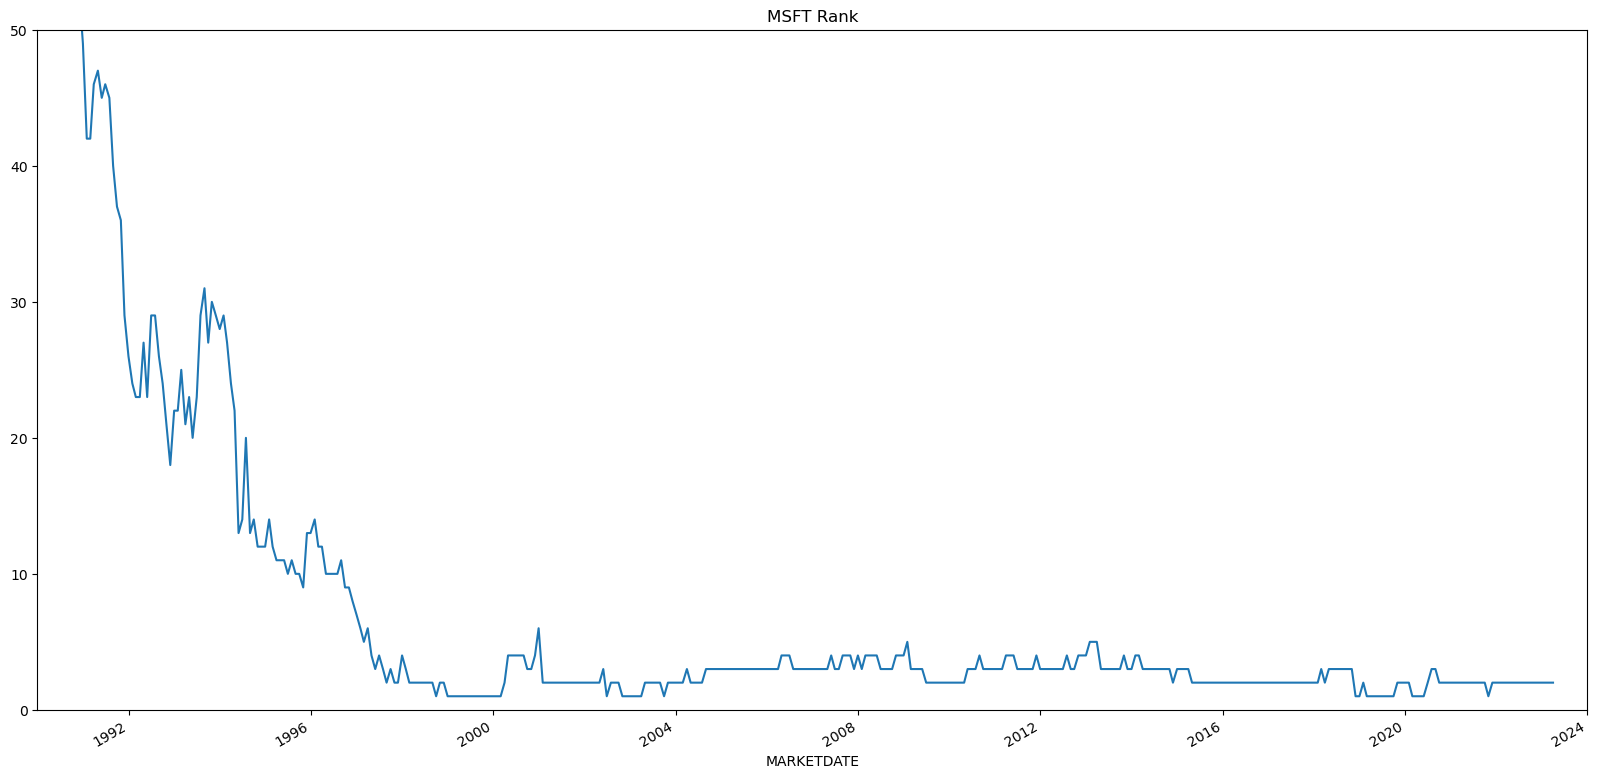

In [41]:
msft = out_df2[out_df2['ID']=='MSFT']["MCAP_RANK"]
#msft.info(0)
msft.plot.line(figsize=(20,10), xlim=[ pd.Timestamp("1990-01-01"), pd.Timestamp("2024-01-01")], ylim=[0,50], title="MSFT Rank")

In [52]:
# Create a dictionary with key as ID from the universe dateframe and value as FALSE
universe_id = universe.index.unique().to_list()
id_open = dict.fromkeys(universe_id, False)
id_start_date = dict.fromkeys(universe_id, None)
id_last_date = dict.fromkeys(universe_id, None)

id_window_count = dict.fromkeys(universe_id, 0)
id_window_list = dict.fromkeys(universe_id, [])
last_date = None

for d in dates:
    df_window = out_df2.loc[d]
    in_list = df_window['ID'].to_list()
    not_in_list = list(set(universe_id) - set(in_list))

    for id in not_in_list:
        if id_open[id] == True:

            id_window_list[id].append(f"{id_start_date[id]}-{id_last_date[id]}")

            id_open[id] = False
            id_start_date[id] = None
            id_last_date[id] = None


    for id in in_list:
        id_last_date[id] = d
        id_window_count[id] += 1

        if id_open[id] == False:
            id_open[id] = True
            id_start_date[id] = d
            #id_window_list[id] = [d]
        

for id in universe_id:
    if id_open[id] == True:
        id_window_list[id].append(f"{id_start_date[id]}-{id_last_date[id]}")
    


In [53]:
df = pd.DataFrame.from_dict(id_window_count, orient='index', columns=['count'])

In [54]:
df.sort_values(by=['count'], ascending=False, inplace=True)
df.head(50)

,count
XOM,399
MSFT,399
HON,399
ABX,399
DE,399
BDX,399
KEY,399
ITW,399
ECL,399
CVS,399


In [55]:
for u in universe_id:
    ws = id_window_count[u]
    wc = len(id_window_list[u])
    str = ",".join(id_window_list[u])
    print(f"{u},{ws},{wc},{str}")

    